## Notebook for Codereview 2

_This notebook is a part of the code review 2._

With this Notebook I want to introduce you to the system I have built.

This notebook requires you to have a OpenAPI Key. You should expects costs of less than 30 cents per notebook run.

### 1. Content Overview

The notebook is structured as follows:

1. [Content Overview](#1.-Content-Overview)
2. [Preparation](#2-preparation)
3. [QA-Generation](#3-QA-Generation)
4. [Retrieval](#4-retrieval)
5. [Visualization](#5-visualize-the-results)

### 2. Preparation
Before you can run the code, you need to do some preparation.

1. Prepare a OpenAI API key. (The costs of running will be between 1-5 cents)
2. Create a [Weights&Biases](https://wandb.ai/login) Account to additionally track the experiments on the Dashboard of Weights&Biases.

First we need to set the API Key for OpenAI. This key is stored on your local system using our SecretManager implementation which stores the key with an encryption key that is stored in your local system.

Run the coded below and you should be prompted to enter the api key if it is not already added to the secretmanager.

In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


from sqa_system.core.data.secret_manager import SecretManager, EndpointType
secret_manager = SecretManager()
try:
    api_key = secret_manager.get_api_key(EndpointType.OPENAI)
    print("API Key found for OpenAI")
except ValueError as e:
    print("No API key found for OpenAI")
    api_key = input("No API key found for OpenAI. Enter your API Key: ")
    secret_manager.save_api_key(EndpointType.OPENAI, api_key)
    print("API Key saved successfully")

Rotating log file
API Key found for OpenAI


### 3. Qa-Generation
First I would like to show you how the questions and answers are generated. I also use this opportunity to show you how the configuration system works. 

A configuration is given as a json file. Every component in the framework has its own configuration files stored in the [data/configs](../../data/configs/) directory which are managed by the [ConfigurationManager](../../sqa_system/core/config/config_manager/implementations/) to distribute the configurations to the components.

The json files are validated when load by the Configuration Manager, however some complex configurations are only validated at a later stage when the components are created. 

Furthermore, because it is hard to know which values are valid without experience with the system (and because it has gotten quite complex), I have created a CLI tool that can be used to generate configurations. This tool is located [here](../../sqa_system/app/cli_controller.py) and should be run from console. 

As you can see below, this is how a configuration for a local RDFLIB graph looks like. The RDFLIB graph is a graph that is stored in memory using the RDFLib library which we will use for demonstration purposes. The configuration tells the framework, which graph to use and how it should be created.

For this codereview I have prepared a KG configuration for you. We will use this to create the graph and then generate questions and answers from it. This configuration is already prepared in the cache so using this **exact** configuration will not have any LLM calls during the generation of the graph.

In [1]:
from sqa_system.core.config.models import KnowledgeGraphConfig
graph_config = {
    "additional_params": { # The building blocks that are used to generate the graph
        "building_blocks": [
            "metadata",
            "authors",
            "publisher",
            "venue",
            "research_field",
            "additional_fields",
            "annotations",
            "content"
        ]
    },
    "graph_type": "local_rdflib",   # We want to use a local graph using the RDFlib library
    "dataset_config": {     # This is a inner configuration that describes the dataset that will be used for the graph creation
        "additional_params": {},
        "file_name": "merged_ecsa_icsa.json",   # This is the file that contains the dataset data
        "loader": "JsonPublicationLoader",  # How the file will be loaded
        "loader_limit": 30  # We limit the number of publications for demonstration.
    },
    "extraction_llm": {    # This is the configuration for the LLM that will be used for extracting data from the dataset
        "additional_params": {},
        "endpoint": "OpenAI",   # We will use the OpenAI API
        "name_model": "gpt-4o-mini",    # We will use the GPT-4o mini model as it is cost efficient and still performs great
        "temperature": 0.1,
        "max_tokens": -1
    }
}
graph_config = KnowledgeGraphConfig.from_dict(graph_config)

# Some default configs are already prepared which can be loaded from the respective configuration manager by name
from sqa_system.core.config.config_manager import LLMConfigManager
llm_config = LLMConfigManager().get_config_by_name("openai_gpt-4o-mini_tmp0.0_maxt-1")

Rotating log file


Running the code above initialized the Knowledge Graph configuration object. We can now use this configuration to create the graph by passing it to the `KnowledgeGraphManager`. This manager is responsible for creating the graph and storing it for the session to allow other parts of the system to access it.

The creation of the graph is a complex process including the steps:
1. Loading the Dataset
2. Extracting the Triples from the Dataset and tracing each triple to its origin
3. Creating the Graph using the triples

Because the creation is time consuming and if using a LLM like OpenAi can include costs, we cache each step using the [CacheManager](../../sqa_system/core/data/cache_manager.py) which stores the data in a SQLite database located in the [data/cache](../../data/cache) directory.

As mentioned above we already cached the data necessary for this configuration which means that the creation of the graph <u>has no further costs</u>.

**Note:** 
We also have a log file that is created that tracks the creation of the graph. This log file is located in the [data/logs](../../logs/log_file.log) directory.

- Creating the graph should take up to 3 minutes depending on your system
- The second run should be instant as the graph is serialized [here](../../data/knowledge_base/knowledge_graphs/) and saved even between runs

In [2]:
# Here we create the graph
from sqa_system.knowledge_base.knowledge_graph.storage import KnowledgeGraphManager
graph = KnowledgeGraphManager().get_item(graph_config) 

# We also load the LLM model using the LLMProvider which is responsible for creating and preparing
# a LLM based on the configuration provided
from sqa_system.core.language_model.llm_provider import LLMProvider
llm_adapter = LLMProvider().get_llm_adapter(llm_config)

# Here we prepare a littler helper to display the QA Pairs 
import pandas as pd
from sqa_system.core.data.models import QAPair
def print_qa_pairs(qa_pairs: list[QAPair]):
    """A little helper function to print the QA pairs"""
    if not qa_pairs:
        print("No QA pairs generated")
    for qa_pair in qa_pairs:
        print(f"Question: {qa_pair.question}")
        print(f"Answer: {qa_pair.golden_answer}")
        print(f"Golden Triples: {qa_pair.golden_triples}")
        print(f"Question Type: {qa_pair.question_type}")
        print(f"Answer Type: {qa_pair.answer_type}")
        print(f"Hops: {qa_pair.hop_amount}")
        df = pd.DataFrame([qa_pair.model_dump()])
        print(f"CSV: \n {df.to_csv(index=False)}")
        print("------------------") 

With our Graph and LLMAdapter prepared, we can now create Questions and Answers using one of the implemented QA-Generation approaches.

In this demonstration we will be using the `FromPublisherGenerator` which works at follows:
1. Find the entry point in the Graph which is a Publisher Node
2. Traverse the Graph and randomly select one of the Publisher's papers
3. Create the subgraph of the Paper
4. Trace the subgraphs triples back to the original text Documents using the [ContextTracer](../../sqa_system/core/data/context_tracer.py)
5. Use the original text chunks to generate questions and answers
6. Validate the generated questions and answers using an LLM (ensuring that there are no hallucinations, the contexts are appropriate, the answer matches, etc.)

Running this code below will generate the question and answer pairs. This requires some LLM calls and if using the OpenAI model will have some costs associated with it. You should expect less than 2 cents for this run.
You can view the process in the log file located at [data/logs](../../logs/log_file.log).

In [3]:
from sqa_system.qa_generator.implementations import FromPublisherGenerator
 
from_publisher_pairs = FromPublisherGenerator(
    graph=graph, # The graph we want to generate questions from
    llm_adapter=llm_adapter,    # The LLM we are using for the question generation
    publisher_name="IEEE", # Can be IEEE or SpringerLink
    template_text="Can we use {approach} to solve {problem explanation}?"  # The template text that will be used for the question generation
    ).generate()

print_qa_pairs(from_publisher_pairs)

Processing generated questions ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

Question: Can we develop an automated detection system to extract the impacted components from advisory reports in industrial control systems?
Answer: Yes, we can develop an automated detection system to extract impacted components from advisory reports in industrial control systems. This is mentioned in the context as a goal of the research.
Golden Triples: ['(Automated Detection System, http://example.org/hasDescription, Developed an automated detection system to extract impacted components from the text data in the advisory reports.)']
Question Type: ['Contingencies']
Answer Type: ['Methodology', 'Solution', 'Research']
Hops: 3
CSV: 
 uid,question,golden_answer,source_ids,golden_doc_chunks,golden_triples,is_generated_with,topic_entity_id,knowledge_representation_type,question_type,question_type_reasoning,answer_type,answer_type_reasoning,information_type,topic_entity_value,hop_amount,based_on_template
ba90d622-4168-4471-800e-7d01c8abed18,Can we develop an automated detection system 

**Important:**
Because the generation of the QAPairs happens by randomly selecting information from the graph, it can happen that no Pairs are created when the randomly selected data does not contain enough information for the template. Rerun the generation in this case.

To add additional pairs, we will also use another strategy which is the `ListingQuestionGenerator`. This generator uses an alternative strategy which clusters the content of the graph using the DBScan algorithm and embeddings. It then creates questions and answers based on the clusters. 

This strategy takes a bit more time to run as creating the clusters is a time consuming process. 

In [3]:
from sqa_system.qa_generator.implementations.clustering_strategy.listing_question_generator import ListingQuestionGenerator, ClusterStrategyOptions
from sqa_system.core.config.config_manager import EmbeddingConfigManager

# Here we use the EmbeddingConfigManager to prepare a preconfigured embedding model 
embedding_config = EmbeddingConfigManager().get_config_by_name("openai_text-embedding-3-small")
embedding_adapter = LLMProvider().get_embeddings(embedding_config)

from_listing_pairs = ListingQuestionGenerator(
    graph=graph,    # The graph we want to generate questions from
    llm_adapter=llm_adapter,    # The LLM we are using for the question generation
    options=ClusterStrategyOptions(
        restriction_type="http://example.org/hasResearchObject",    # The predicate type that will be used for the clustering
        template_text="Which publications [.. continue question]?", # The template text that the LLM will use for the question generation
        cluster_eps=0.05,   # The similarity between the embeddings to be clustered together
        cluster_metric="cosine",    # The metric that will be used for the clustering
        cluster_emb_model=embedding_adapter,    # The embedding model that will be used for the clustering
        golden_triple_limit=10  # To not generate questions asking for too many triples at once
    )
).generate()

print_qa_pairs(from_listing_pairs)

Processing generated questions ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

Question: Which publications discuss the concept of reference architecture in the context of software architecture adaptability and service-based systems?
Answer: The publications that discuss the concept of Reference Architecture in the context of software architecture adaptability and service-based systems are: 1. "Assessing Adaptability of Software Architectures for Cyber Physical Production Systems" 2. "Updating Service-Based Software Systems in Air-Gapped Environments".
Golden Triples: ['(Assessing Adaptability of Software Architectures for Cyber Physical Production Systems, http://example.org/hasResearchObject, Reference Architecture)', '(Updating Service-Based Software Systems in Air-Gapped Environments, http://example.org/hasResearchObject, Reference Architecture)']
Question Type: ['List/Combine']
Answer Type: ['Concept', 'Research']
Hops: None
CSV: 
 uid,question,golden_answer,source_ids,golden_doc_chunks,golden_triples,is_generated_with,topic_entity_id,knowledge_representatio

Before these generated QAPairs can be used, we validate them manually to ensure that they are correct and relevant. But for this demonstration we skip the manual validation and directly use the generated QAPairs in our subsequent experimentation. We store the QAPairs so that our [ExperimentRunner](../../sqa_system/experimentation/experiment_runner.py) can use them.

In [7]:
import random
from sqa_system.core.data.file_path_manager import FilePathManager
from sqa_system.core.data.models import QADataset
fpm = FilePathManager()
merged_pairs = from_listing_pairs
merged_pairs.extend(from_listing_pairs)
# Shuffle and only select 5 pairs to reduce costs
random.shuffle(merged_pairs)
merged_pairs = merged_pairs[:5]
qa_dataset = QADataset.from_qa_pairs("codereview", merged_pairs)
qa_dataset.save_as_csv(fpm.get_path("question_answering_codereview.csv"))

### 4. Retrieval
Now we start the experimentation. I have prepared several configurations for you to run and then visualize the results. We first have the HubLink Retrieval approach (our new approach) and then two baselines.

#### HubLink Retriever
Below I have prepared a configuration for you to run the HubLink Retrieval approach. This configuration is already indexed so the amount of LLM calls is minimized.

The retriever has several parameters that can be configured as you can see in the configuration below. These configs allow to reproduce the experiments and to test different configurations of the retriever. Hyperparameter optimization can also be done using the `parameter_ranges` field in the configuration.

Run the code below to prepare the configuration.

In [1]:
from sqa_system.core.config.models import ExperimentConfig
experiment_dict = {
    "additional_params": {},
    "base_pipeline_config": {
        "additional_params": {},
        "pipes": [
            {
                "additional_params": {
                    "embedding_config": {
                        "additional_params": {},
                        "endpoint": "OpenAI",
                        "name_model": "text-embedding-3-small"
                    },
                    "max_workers": 8,
                    "number_of_hubs": 5,
                    "top_paths_to_keep": 10,
                    "run_indexing": True,
                    "indexing_root_entity_types": "",
                    "force_index_update": False,
                    "max_hub_path_length": 10,
                    "force_hub_update": False,
                    "hub_types": "",
                    "hub_edges": -1,
                    "use_topic_if_given": False,
                    "compare_hubs_with_same_hop_amount": True,
                    "max_level": 5,
                    "use_source_documents": True,
                    "source_vector_store_config": {
                        "additional_params": {
                            "distance_metric": "l2"
                        },
                        "vector_store_type": "chroma",
                        "chunking_strategy_config": {
                            "additional_params": {},
                            "chunking_strategy_type": "RecursiveCharacterChunkingStrategy",
                            "chunk_size": 500,
                            "chunk_overlap": 0
                        },
                        "embedding_config": {
                            "additional_params": {},
                            "endpoint": "OpenAI",
                            "name_model": "text-embedding-3-small"
                        },
                        "dataset_config": {
                            "additional_params": {},
                            "file_name": "merged_ecsa_icsa.json",
                            "loader": "JsonPublicationLoader",
                            "loader_limit": 3
                        }
                    }
                },
                "type": "kg_retrieval",
                "retriever_type": "hublink",
                "llm_config": {
                    "additional_params": {},
                    "endpoint": "OpenAI",
                    "name_model": "gpt-4o-mini",
                    "temperature": 0.1,
                    "max_tokens": -1
                },
                "knowledge_graph_config": {
                    "additional_params": {
                        "building_blocks": [
                            "metadata",
                            "authors",
                            "publisher",
                            "venue",
                            "research_field",
                            "additional_fields",
                            "annotations"
                        ]
                    },
                    "graph_type": "local_rdflib",
                    "dataset_config": {
                        "additional_params": {},
                        "file_name": "merged_ecsa_icsa.json",
                        "loader": "JsonPublicationLoader",
                        "loader_limit": 3
                    },
                    "extraction_llm": {
                        "additional_params": {},
                        "endpoint": "OpenAI",
                        "name_model": "gpt-4o-mini",
                        "temperature": 0.1,
                        "max_tokens": -1
                    }
                }
            },
            {
                "additional_params": {},
                "type": "generation",
                "llm_config": {
                    "additional_params": {},
                    "endpoint": "OpenAI",
                    "name_model": "gpt-4o-mini",
                    "temperature": 0.1,
                    "max_tokens": -1
                }
            }
        ]
    },
    "parameter_ranges": [],
    "evaluators": [
{
                    "name": "hit_at_k",
                    "additional_params": {
                        "k": 10,
                        "context_type": "triple"
                    },
                    "evaluator_type": "hit_at_k"
                },
                {
                    "name": "hit_at_k",
                    "additional_params": {
                        "k": 10,
                        "context_type": "entity"
                    },
                    "evaluator_type": "hit_at_k"
                },
                {
                    "name": "hit_at_k",
                    "additional_params": {
                        "k": 10,
                        "context_type": "triple"
                    },
                    "evaluator_type": "hit_at_k"
                },
                {
                    "name": "map_at_k",
                    "additional_params": {
                        "k": 10,
                        "context_type": "triple"
                    },
                    "evaluator_type": "map_at_k"
                },
                {
                    "name": "map_at_k",
                    "additional_params": {
                        "k": 10,
                        "context_type": "entity"
                    },
                    "evaluator_type": "map_at_k"
                },
                {
                    "name": "mrr_at_k",
                    "additional_params": {
                        "k": 10,
                        "context_type": "triple"
                    },
                    "evaluator_type": "mrr_at_k"
                },
                {
                    "name": "mrr_at_k",
                    "additional_params": {
                        "k": 10,
                        "context_type": "entity"
                    },
                    "evaluator_type": "mrr_at_k"
                },
                {
                    "name": "basic_score",
                    "additional_params": {
                        "k": 10,
                        "context_type": "triple"
                    },
                    "evaluator_type": "basic_score"
                },
                {
                    "name": "basic_score",
                    "additional_params": {
                        "k": 10,
                        "context_type": "entity"
                    },
                    "evaluator_type": "basic_score"
                },
                {
                    "name": "basic_score",
                    "additional_params": {
                        "k": -1,
                        "context_type": "triple"
                    },
                    "evaluator_type": "basic_score"
                },
                {
                    "name": "basic_score",
                    "additional_params": {
                        "k": -1,
                        "context_type": "entity"
                    },
                    "evaluator_type": "basic_score"
                },
                {
                    "name": "exact_match",
                    "additional_params": {
                        "k": 10,
                        "context_type": "triple"
                    },
                    "evaluator_type": "exact_match"
                },
                {
                    "name": "exact_match",
                    "additional_params": {
                        "k": 10,
                        "context_type": "entity"
                    },
                    "evaluator_type": "exact_match"
                },
                {
                    "name": "exact_match",
                    "additional_params": {
                        "k": -1,
                        "context_type": "triple"
                    },
                    "evaluator_type": "exact_match"
                },
                {
                    "name": "exact_match",
                    "additional_params": {
                        "k": -1,
                        "context_type": "entity"
                    },
                    "evaluator_type": "exact_match"
                }
    ],
    "qa_dataset": {
        "additional_params": {},
        "file_name": "question_answering_codereview.csv",
        "loader": "CSVQALoader",
        "loader_limit": -1
    }
}
experiment_config = ExperimentConfig.from_dict(experiment_dict)

import os
from sqa_system.core.data.file_path_manager import FilePathManager

# Here we prepare the location where the results of the experiment will be stored
file_path_manager = FilePathManager()
current_directory = os.getcwd()
folder_path = file_path_manager.combine_paths(current_directory, "experiment_data_openai")
experiment_folder = file_path_manager.combine_paths(folder_path, experiment_config.base_pipeline_config.config_hash)
print(f"Results will be stored in {experiment_folder}")

Results will be stored in /home/marco/master_thesis_implementation/sqa-system/notebooks/codereview/experiment_data_openai/272baa802f2e55e974249f9846308735


Now we can use the configuration to run the experiment. The experiment runner will use the configuration to create the retriever, load the QAPairs and run the experiment. 

The indexing process for this configuration has already been done and should be cached. Therefore running this code will cost around 8 cent. Just as information, the initial indexing process took around 10 minutes and cost about 20 cents.

Interestingly, the retriever alone would cost less than 1 cent but to run the LLM based evaluation metrics we need to use the LLM which is the most expensive part of the experiment.

In [2]:
from sqa_system.experimentation.experiment_runner import ExperimentRunner

# We can now run the experiment using the ExperimentRunner
runner = ExperimentRunner(
    experiment_config=experiment_config,
    results_folder_path=experiment_folder,
)
results = runner.run()
results.head()

Rotating log file


Output()

weave version 0.51.33 is available!  To upgrade, please run:
 $ pip install weave --upgrade
Logged in as Weights & Biases user: marco_kit.
View Weave data at https://wandb.ai/kastel-sdq-meta-research/ma_mschneider_experiment_run/weave


AttributeError: 'ChatOpenAI' object has no attribute 'get'

Great, now that the experiment finished, the results are stored in the experiment_data folder in the same folder of this notebook. This folder is generated by the experiment runner and contains 3 subfolders.
1. configs: Contains the configuration(s) that have been used to run the experiment. This allows to check the configuration that was used for the experiment at any point at a later time. 
2. predictions: This includes the predictions stored as `.csv` files. Feel free to look at the file and review if anything is missing.
3. visualizations: This folder contains visualizations done by the runner to get a feel for the performance of the retriever. These will not be the final visualizations but are helpful to get a quick overview of the performance.

#### Baseline: DocumentEmbed Retriever
We need something to compare against so I also prepared two baselines for you. The first one is the DocumentEmbed Retriever. This retriever doesn't use a KG but instead directly embeds the fulltexts of the documents and stores them in a vector store. The retriever then uses the vector store to retrieve the most similar document to the question.

In [3]:
from sqa_system.core.config.config_manager import ExperimentConfigManager
experiment_config = ExperimentConfigManager().get_config_by_name("DocumentEmbed_Codereview")
experiment_folder = file_path_manager.combine_paths(folder_path, experiment_config.base_pipeline_config.config_hash)
print(f"Results will be stored in {experiment_folder}")

Results will be stored in /home/marco/master_thesis_implementation/sqa-system/notebooks/codereview/data/bee110b0ae7419cac5884d8cc34e2dda


In [4]:
from sqa_system.experimentation.experiment_runner import ExperimentRunner

# We can now run the experiment using the ExperimentRunner
runner = ExperimentRunner(
    experiment_config=experiment_config,
    results_folder_path=experiment_folder,
)
results = runner.run()
results.head()

Output()

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluated 1 of 5 examples

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluated 2 of 5 examples

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluated 3 of 5 examples

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluated 4 of 5 examples

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluated 5 of 5 examples

Evaluation summary
{
    'RagasEvaluator': {
        'llm_context_precision_with_reference': {'mean': 0.22800000000000004},
        'bleu_score': {'mean': 0.178},
        'factual_correctness_precision': {'mean': 0.05},
        'llm_context_precision_without_reference': {'mean': 0.0},
        'non_llm_string_similarity': {'mean': 0.314},
        'context_recall': {'mean': 0.368},
        'faithfulness': {'mean': 0.9460000000000001},
        'context_entity_recall': {'mean': 0.028000000000000004},
        'factual_correctness_recall': {'mean': 0.04},
        'semantic_similarity': {'mean': 0.718},
        'rouge_score': {'mean': 0.29600000000000004},
        'answer_relevancy': {'mean': 0.0},
        'factual_correctness_f1': {'mean': 0.03},
        'row_scores': [
            {
                'factual_correctness_f1': 0.0,
                'factual_correctness_precision': 0.0,
                'factual_correctness_recall': 0.0,
                'faithfulness': 1.0,
                'context_recall': 0.5,
                'llm_context_precision_without_reference': 0.0,
                'llm_context_precision_with_reference': 0.34,
                'context_entity_recall': 0.0,
                'answer_relevancy': 0.0,
                'semantic_similarity': 0.75,
                'non_llm_string_similarity': 0.27,
                'bleu_score': 0.25,
                'rouge_score': 0.39
            },
            {
                'factual_correctness_f1': 0.0,
                'factual_correctness_precision': 0.0,
                'factual_correctness_recall': 0.0,
                'faithfulness': 1.0,
                'context_recall': 0.0,
                'llm_context_precision_without_reference': 0.0,
                'llm_context_precision_with_reference': 0.0,
                'context_entity_recall': 0.0,
                'answer_relevancy': 0.0,
                'semantic_similarity': 0.63,
                'non_llm_string_similarity': 0.26,
                'bleu_score': 0.06,
                'rouge_score': 0.27
            },
            {
                'factual_correctness_f1': 0.0,
                'factual_correctness_precision': 0.0,
                'factual_correctness_recall': 0.0,
                'faithfulness': 0.83,
                'context_recall': 0.67,
                'llm_context_precision_without_reference': 0.0,
                'llm_context_precision_with_reference': 0.0,
                'context_entity_recall': 0.14,
                'answer_relevancy': 0.0,
                'semantic_similarity': 0.69,
                'non_llm_string_similarity': 0.33,
                'bleu_score': 0.15,
                'rouge_score': 0.26
            },
            {
                'factual_correctness_f1': 0.15,
                'factual_correctness_precision': 0.25,
                'factual_correctness_recall': 0.2,
                'faithfulness': 0.9,
                'context_recall': 0.67,
                'llm_context_precision_without_reference': 0.0,
                'llm_context_precision_with_reference': 0.8,
                'context_entity_recall': 0.0,
                'answer_relevancy': 0.0,
                'semantic_similarity': 0.82,
                'non_llm_string_similarity': 0.29,
                'bleu_score': 0.22,
                'rouge_score': 0.23
            },
            {
                'factual_correctness_f1': 0.0,
                'factual_correctness_precision': 0.0,
                'factual_correctness_recall': 0.0,
                'faithfulness': 1.0,
                'context_recall': 0.0,
                'llm_context_precision_without_reference': 0.0,
                'llm_context_precision_with_reference': 0.0,
                'context_entity_recall': 0.0,
                'answer_relevancy': 0.0,
                'semantic_similarity': 0.7,
                'non_llm_string_similarity': 0.42,
                'bleu_score': 0.21,
                'rouge_score': 0.33
            }
        ]
    },
    'HitAtKEvaluat

🍩 https://wandb.ai/marco_kit/ma_mschneider_experiment_run/r/call/01943c72-211a-7493-985c-fece83cbee70

/home/marco/master_thesis_implementation/sqa-system/sqa_system/experimentation/utils/experiment_visualizer.py:265: UserWarning: The palette list has more values (11) than needed (1), which may not be intended.
  sns.boxplot(data=melted_data, x='Metric', y='Value', hue='config_hash', palette=COLOR_LIST)
/home/marco/master_thesis_implementation/sqa-system/sqa_system/experimentation/utils/experiment_visualizer.py:295: UserWarning: The palette list has more values (11) than needed (1), which may not be intended.
  sns.barplot(x='Metric', y='Average Score', hue='config_hash',


,config_hash,uid,question_result,golden_answer_result,golden_triples_result,topic_entity_id_result,topic_entity_value_result,is_generated_with_result,knowledge_representation_type_result,question_type_result,...,topic_entity_id_question,knowledge_representation_type_question,question_type_question,question_type_reasoning_question,answer_type_question,answer_type_reasoning_question,information_type_question,topic_entity_value_question,hop_amount_question,based_on_template_question
0,bee110b0ae7419cac5884d8cc34e2dda,62aebb0f-4899-414c-8d2f-23e8c2902980,"Can we use a generic, modular, and highly scal...","Yes, we can use a generic, modular, and highly...",[(Generic and Modular Process Operation Framew...,http://ressource.org/publisher_1,IEEE,llm_extraction_strategy,None,"['Contingencies', 'Comparisons']",...,http://ressource.org/publisher_1,None,"['Contingencies', 'Comparisons']",Contingencies is appropriate because the quest...,"['Methodology', 'Research']",The question pertains to the use of a framewor...,None,IEEE,3,None
1,bee110b0ae7419cac5884d8cc34e2dda,e2d63471-7a68-4dcb-9fc7-0a854d014081,Can we use Apache NiFi to create a user-friend...,"Yes, Apache NiFi provides an easy-to-use web u...","[(Apache NiFi Integration, http://example.org/...",http://ressource.org/publisher_1,IEEE,llm_extraction_strategy,None,"['Contingencies', 'Comparisons']",...,http://ressource.org/publisher_1,None,"['Contingencies', 'Comparisons']",Contingencies is appropriate because the quest...,"['Methodology', 'Solution']",The question pertains to the use of Apache NiF...,None,IEEE,3,None
2,bee110b0ae7419cac5884d8cc34e2dda,11b84e26-3294-471f-96b8-3ce9ba1b833d,Can we use Docker containerization to facilita...,"Yes, Docker containerization can be used to fa...","[(Container Automation Technology, http://exam...",http://ressource.org/publisher_1,IEEE,llm_extraction_strategy,None,"['Contingencies', 'Comparisons']",...,http://ressource.org/publisher_1,None,"['Contingencies', 'Comparisons']",Contingencies is appropriate because the quest...,"['Methodology', 'Procedure', 'Model']",The question pertains to the use of Docker con...,None,IEEE,3,None
3,bee110b0ae7419cac5884d8cc34e2dda,fcfd56bb-ebf0-4484-bd8d-4e2d7971dea8,Can we use microservices architecture to impro...,"Yes, microservices architecture can enhance th...","[(Microservices Architecture, http://example.o...",http://ressource.org/publisher_1,IEEE,llm_extraction_strategy,None,"['Contingencies', 'Multple Intentions']",...,http://ressource.org/publisher_1,None,"['Contingencies', 'Multple Intentions']",Contingencies is appropriate because the quest...,"['Methodology', 'Concept', 'Solution']",The question pertains to the use of microservi...,None,IEEE,3,None
4,bee110b0ae7419cac5884d8cc34e2dda,7265fdfb-4337-48b6-ba7f-87a0a0eb43dc,Can we use Apache Kafka to manage low-latency ...,"Yes, Apache Kafka is a message-oriented, distr...","[(Apache Kafka, http://example.org/hasDescript...",http://ressource.org/publisher_1,IEEE,llm_extraction_strategy,None,"['Contingencies', 'Comparisons']",...,http://ressource.org/publisher_1,None,"['Contingencies', 'Comparisons']",Contingencies is appropriate because the quest...,"['Methodology', 'Concept', 'Solution']",The question pertains to the use of Apache Kaf...,None,IEEE,3,None


#### Baseline: TripleEmbed Retriever
The second baseline is the TripleEmbed Retriever. This retriever uses the triples of the graph and embeds them. The retriever then uses the vector store to retrieve the most similar triple to the question.

In [2]:
from sqa_system.core.config.config_manager import ExperimentConfigManager
experiment_config = ExperimentConfigManager().get_config_by_name("TripleEmbed_Codereview")
experiment_folder = file_path_manager.combine_paths(folder_path, experiment_config.base_pipeline_config.config_hash)
print(f"Results will be stored in {experiment_folder}")

Rotating log file
Results will be stored in /home/marco/master_thesis_implementation/sqa-system/notebooks/codereview/data/46d384f4794a956e10e056d446fdea6f


In [3]:
from sqa_system.experimentation.experiment_runner import ExperimentRunner

# We can now run the experiment using the ExperimentRunner
runner = ExperimentRunner(
    experiment_config=experiment_config,
    results_folder_path=experiment_folder,
)
results = runner.run()
results.head()

Output()

weave version 0.51.27 is available!  To upgrade, please run:
 $ pip install weave --upgrade
Logged in as Weights & Biases user: marco_kit.
View Weave data at https://wandb.ai/marco_kit/ma_mschneider_experiment_run/weave


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

WARNING:urllib3.connectionpool:Connection pool is full, discarding connection: trace.wandb.ai. Connection pool 
size: 10

Evaluated 1 of 5 examples

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluated 2 of 5 examples

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluated 3 of 5 examples

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluated 4 of 5 examples

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluated 5 of 5 examples

Evaluation summary
{
    'RagasEvaluator': {
        'semantic_similarity': {'mean': 0.942},
        'answer_relevancy': {'mean': 0.6799999999999999},
        'rouge_score': {'mean': 0.576},
        'context_recall': {'mean': 0.666},
        'factual_correctness_f1': {'mean': 0.7040000000000001},
        'non_llm_string_similarity': {'mean': 0.5479999999999999},
        'bleu_score': {'mean': 0.39799999999999996},
        'faithfulness': {'mean': 0.834},
        'factual_correctness_precision': {'mean': 0.694},
        'factual_correctness_recall': {'mean': 0.78},
        'context_entity_recall': {'mean': 0.14600000000000002},
        'llm_context_precision_without_reference': {'mean': 0.9480000000000001},
        'llm_context_precision_with_reference': {'mean': 0.9339999999999999},
        'row_scores': [
            {
                'factual_correctness_f1': 0.44,
                'factual_correctness_precision': 0.29,
                'factual_correctness_recall': 1.0,
                'faithfulness': 0.86,
                'context_recall': 0.5,
                'llm_context_precision_without_reference': 1.0,
                'llm_context_precision_with_reference': 1.0,
                'context_entity_recall': 0.0,
                'answer_relevancy': 0.94,
                'semantic_similarity': 0.96,
                'non_llm_string_similarity': 0.57,
                'bleu_score': 0.48,
                'rouge_score': 0.63
            },
            {
                'factual_correctness_f1': 0.83,
                'factual_correctness_precision': 0.8,
                'factual_correctness_recall': 0.67,
                'faithfulness': 0.6,
                'context_recall': 1.0,
                'llm_context_precision_without_reference': 0.88,
                'llm_context_precision_with_reference': 0.79,
                'context_entity_recall': 0.25,
                'answer_relevancy': 0.96,
                'semantic_similarity': 0.92,
                'non_llm_string_similarity': 0.32,
                'bleu_score': 0.12,
                'rouge_score': 0.42
            },
            {
                'factual_correctness_f1': 0.8,
                'factual_correctness_precision': 1.0,
                'factual_correctness_recall': 0.67,
                'faithfulness': 1.0,
                'context_recall': 1.0,
                'llm_context_precision_without_reference': 0.86,
                'llm_context_precision_with_reference': 0.92,
                'context_entity_recall': 0.14,
                'answer_relevancy': 0.87,
                'semantic_similarity': 0.96,
                'non_llm_string_similarity': 0.56,
                'bleu_score': 0.33,
                'rouge_score': 0.57
            },
            {
                'factual_correctness_f1': 0.45,
                'factual_correctness_precision': 0.38,
                'factual_correctness_recall': 0.56,
                'faithfulness': 0.71,
                'context_recall': 0.33,
                'llm_context_precision_without_reference': 1.0,
                'llm_context_precision_with_reference': 0.96,
                'context_entity_recall': 0.2,
                'answer_relevancy': 0.0,
                'semantic_similarity': 0.88,
                'non_llm_string_similarity': 0.35,
                'bleu_score': 0.2,
                'rouge_score': 0.29
            },
            {
                'factual_correctness_f1': 1.0,
                'factual_correctness_precision': 1.0,
                'factual_correctness_recall': 1.0,
                'faithfulness': 1.0,
                'context_recall': 0.5,
                'llm_context_precision_without_reference': 1.0,
                'llm_context_precision_with_reference': 1.0,
                'context_entity_recall': 0.14,
                'answer_relevancy': 0.63,
                'semantic_similarity': 0.99,
                'non_llm_string_similarity': 0.94,
                'bleu_score': 0.86,
                'rouge_sco

🍩 https://wandb.ai/marco_kit/ma_mschneider_experiment_run/r/call/01943c78-61d8-7802-8409-38f447ff3930

/home/marco/master_thesis_implementation/sqa-system/sqa_system/experimentation/utils/experiment_visualizer.py:265: UserWarning: The palette list has more values (11) than needed (1), which may not be intended.
  sns.boxplot(data=melted_data, x='Metric', y='Value', hue='config_hash', palette=COLOR_LIST)
/home/marco/master_thesis_implementation/sqa-system/sqa_system/experimentation/utils/experiment_visualizer.py:295: UserWarning: The palette list has more values (11) than needed (1), which may not be intended.
  sns.barplot(x='Metric', y='Average Score', hue='config_hash',


,config_hash,uid,question_result,golden_answer_result,golden_triples_result,topic_entity_id_result,topic_entity_value_result,is_generated_with_result,knowledge_representation_type_result,question_type_result,...,topic_entity_id_question,knowledge_representation_type_question,question_type_question,question_type_reasoning_question,answer_type_question,answer_type_reasoning_question,information_type_question,topic_entity_value_question,hop_amount_question,based_on_template_question
0,46d384f4794a956e10e056d446fdea6f,62aebb0f-4899-414c-8d2f-23e8c2902980,"Can we use a generic, modular, and highly scal...","Yes, we can use a generic, modular, and highly...",[(Generic and Modular Process Operation Framew...,http://ressource.org/publisher_1,IEEE,llm_extraction_strategy,None,"['Contingencies', 'Comparisons']",...,http://ressource.org/publisher_1,None,"['Contingencies', 'Comparisons']",Contingencies is appropriate because the quest...,"['Methodology', 'Research']",The question pertains to the use of a framewor...,None,IEEE,3,None
1,46d384f4794a956e10e056d446fdea6f,e2d63471-7a68-4dcb-9fc7-0a854d014081,Can we use Apache NiFi to create a user-friend...,"Yes, Apache NiFi provides an easy-to-use web u...","[(Apache NiFi Integration, http://example.org/...",http://ressource.org/publisher_1,IEEE,llm_extraction_strategy,None,"['Contingencies', 'Comparisons']",...,http://ressource.org/publisher_1,None,"['Contingencies', 'Comparisons']",Contingencies is appropriate because the quest...,"['Methodology', 'Solution']",The question pertains to the use of Apache NiF...,None,IEEE,3,None
2,46d384f4794a956e10e056d446fdea6f,11b84e26-3294-471f-96b8-3ce9ba1b833d,Can we use Docker containerization to facilita...,"Yes, Docker containerization can be used to fa...","[(Container Automation Technology, http://exam...",http://ressource.org/publisher_1,IEEE,llm_extraction_strategy,None,"['Contingencies', 'Comparisons']",...,http://ressource.org/publisher_1,None,"['Contingencies', 'Comparisons']",Contingencies is appropriate because the quest...,"['Methodology', 'Procedure', 'Model']",The question pertains to the use of Docker con...,None,IEEE,3,None
3,46d384f4794a956e10e056d446fdea6f,fcfd56bb-ebf0-4484-bd8d-4e2d7971dea8,Can we use microservices architecture to impro...,"Yes, microservices architecture can enhance th...","[(Microservices Architecture, http://example.o...",http://ressource.org/publisher_1,IEEE,llm_extraction_strategy,None,"['Contingencies', 'Multple Intentions']",...,http://ressource.org/publisher_1,None,"['Contingencies', 'Multple Intentions']",Contingencies is appropriate because the quest...,"['Methodology', 'Concept', 'Solution']",The question pertains to the use of microservi...,None,IEEE,3,None
4,46d384f4794a956e10e056d446fdea6f,7265fdfb-4337-48b6-ba7f-87a0a0eb43dc,Can we use Apache Kafka to manage low-latency ...,"Yes, Apache Kafka is a message-oriented, distr...","[(Apache Kafka, http://example.org/hasDescript...",http://ressource.org/publisher_1,IEEE,llm_extraction_strategy,None,"['Contingencies', 'Comparisons']",...,http://ressource.org/publisher_1,None,"['Contingencies', 'Comparisons']",Contingencies is appropriate because the quest...,"['Methodology', 'Concept', 'Solution']",The question pertains to the use of Apache Kaf...,None,IEEE,3,None


### 5. Visualize the Results
We can also visualize the results using the `ExperimentVisualizer`. This visualizer provides several plots to compare the performances of the retrievers. It is provided with a folder path and searches the folder path for valid prediction files by crawling through the subfolders. It then matches the questions by their ID and the unique ID of the configuration to generate the plot.

This is why you only see a long hash ID in the plot. For each configuration a unique hash is generated. This means that if we change even a single parameter in the config, its ID will change which makes it easy when comparing different configurations. It also makes sure that if we by chance run the same configuration twice, we can recognize this by the ID.

To find out what ID constitutes to what configuration, we can look at the results folder `experiment_data` and find the configuration file that was used for the experiment.

Looking at the results, it is expected that the baselines are close to the retrieval performance of our retriever. This is because of several reasons. 
1. The question types generated with the generator we used
2. The low amount of data that we used

/home/marco/master_thesis_implementation/sqa-system/sqa_system/experimentation/utils/experiment_visualizer.py:295: UserWarning: The palette list has more values (11) than needed (4), which may not be intended.
  sns.barplot(x='Metric', y='Average Score', hue='config_hash',


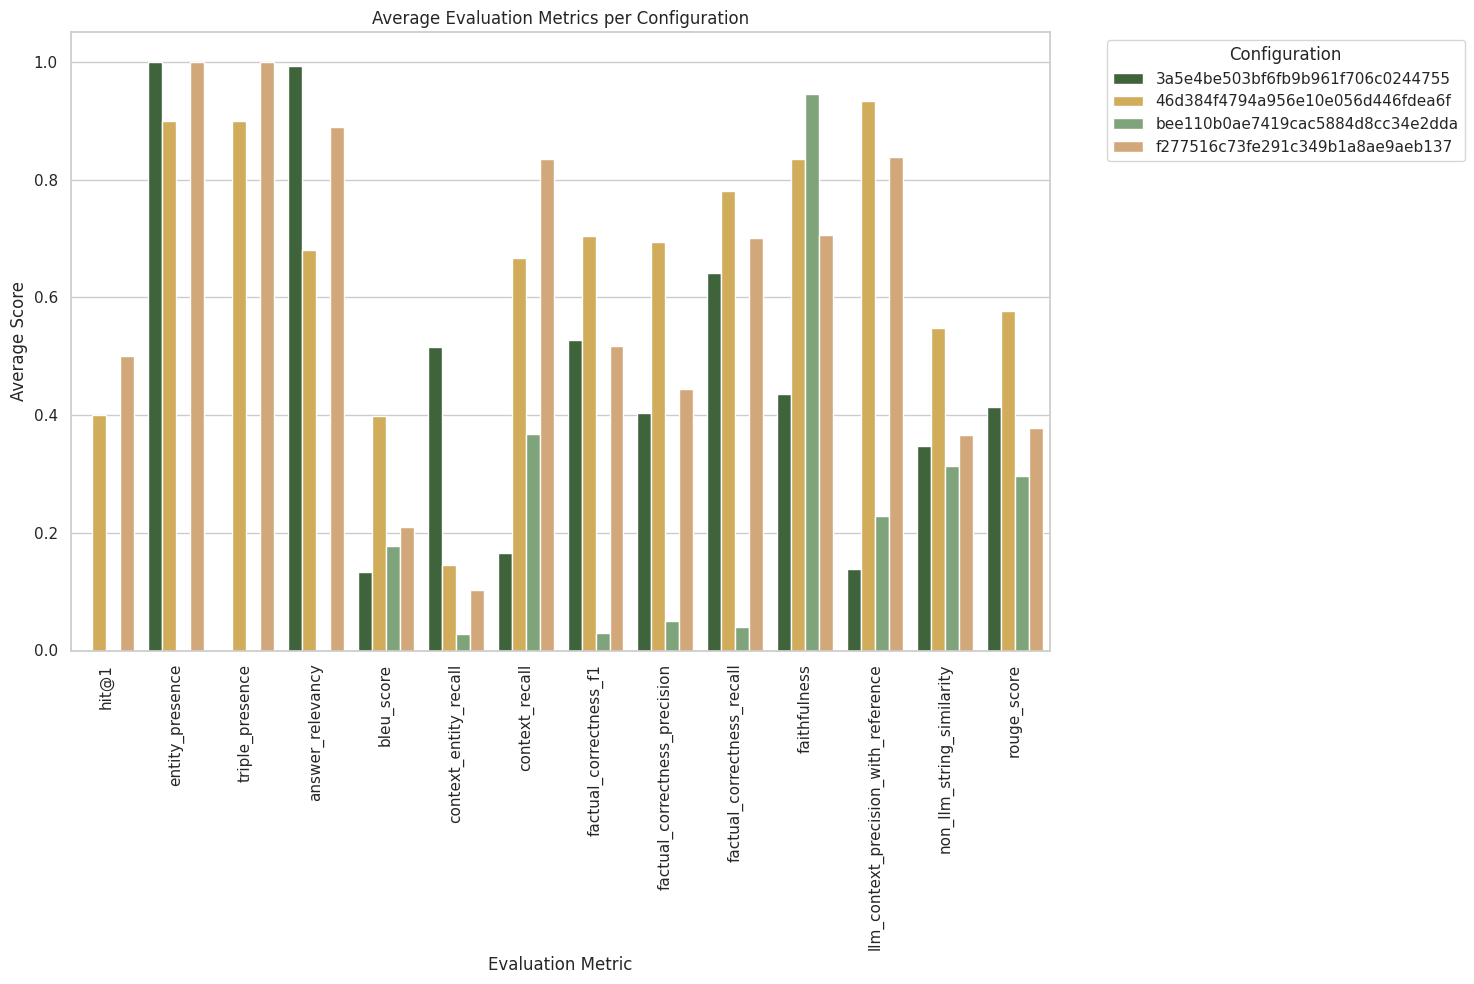

In [3]:
from sqa_system.experimentation.utils.visualizer.experiment_visualizer import ExperimentVisualizer, PlotType
visualizer = ExperimentVisualizer(
    data_folder_path=folder_path,
    should_print=True,
    should_save_to_file=False,
)
visualizer.run(plots_to_generate=[PlotType.AVERAGE_METRICS_PER_CONFIG])